In [1]:
### WIP



In [2]:
# https://github.com/SeldonIO/alibi-detect#drift-detection

In [3]:
#pip  install alibi-detect --user
#pip  install tensorflow

#pip  install alibi
# !pip install catboost
# !pip install shap
# !pip install xgboost


In [4]:


import alibi
import matplotlib.pyplot as plt

from alibi_detect.cd import TabularDrift
from alibi_detect.utils.saving import save_detector, load_detector


import pandas as pd
import numpy as np
import matplotlib as mat
import matplotlib.pyplot as plt    
import seaborn as sns
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from catboost import Pool

import shap

import warnings

In [5]:
data = pd.read_csv('data.csv')

# cd = MMDDrift(x_ref, backend='tensorflow', p_val=.05)
# preds = cd.predict(x)

In [6]:
data.head(5)


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,148,Male,0,No,No,1,Yes,No,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,45.65,45.65,Yes
1,463,Male,0,Yes,Yes,4,Yes,Yes,Fiber optic,No,...,Yes,No,Yes,Yes,Month-to-month,No,Electronic check,101.15,385.90,Yes
2,471,Female,1,No,No,17,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,One year,No,Mailed check,20.65,330.60,No
3,496,Male,0,No,No,22,No,No phone service,DSL,No,...,Yes,No,No,Yes,One year,Yes,Bank transfer (automatic),43.75,903.60,Yes
4,833,Female,0,Yes,Yes,70,Yes,No,DSL,Yes,...,Yes,Yes,No,Yes,One year,No,Credit card (automatic),74.10,5222.30,No


In [34]:
# do all data massaging
# Convert binary variable into numeric so plotting is easier. We need to later take mean
data['Churn'] = data['Churn'].map({'Yes': 1, 'No': 0})

data.replace(" ", np.nan, inplace=True)

data['TotalCharges'] = pd.to_numeric(data['TotalCharges'])

mean = data['TotalCharges'].mean()
data.fillna(mean, inplace=True)
data_enc = data.drop(['Churn', 'customerID'], axis=1)
data_enc.head(5)
labels = data['Churn']


categories_per_feature = ['MultipleLines', 'InternetService', 'Contract', 'PaymentMethod', 'OnlineSecurity', 'OnlineBackup',
         'DeviceProtection', 'TechSupport']



# import category_encoders as ce
# import joblib

# names = ['gender', 'Partner', 'Dependents', 'PhoneService', 'StreamingTV', 'StreamingMovies', 'PaperlessBilling']
# # for column in names:
# #     labelencoder(column)
# data_enc = data
# data_enc = data_enc.drop(['Churn', 'customerID'], axis=1)
# enc = ce.ordinal.OrdinalEncoder(cols=names)
# enc.fit(data_enc)
# labelled_set = enc.transform(data_enc)

# categories_per_feature = ['MultipleLines', 'InternetService', 'Contract', 'PaymentMethod', 'OnlineSecurity', 'OnlineBackup',
#          'DeviceProtection', 'TechSupport']

# ohe = ce.OneHotEncoder(cols=names)
# data_ohe = data
# data_ohe = data_ohe.drop(['Churn', 'customerID'], axis=1)
# ohe.fit(data_ohe)
# final_set = ohe.transform(labelled_set)

data_enc.head(5)

,gender_1,gender_2,SeniorCitizen,Partner_1,Partner_2,Dependents_1,Dependents_2,tenure,PhoneService_1,PhoneService_2,...,StreamingTV_3,StreamingMovies_1,StreamingMovies_2,StreamingMovies_3,Contract,PaperlessBilling_1,PaperlessBilling_2,PaymentMethod,MonthlyCharges,TotalCharges
0,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,Month-to-month,0,0,Electronic check,45.65,45.65
1,0,0,0,0,0,0,0,4,0,0,...,0,0,0,0,Month-to-month,0,0,Electronic check,101.15,385.90
2,0,0,1,0,0,0,0,17,0,0,...,0,0,0,0,One year,0,0,Mailed check,20.65,330.60
3,0,0,0,0,0,0,0,22,0,0,...,0,0,0,0,One year,0,0,Bank transfer (automatic),43.75,903.60
4,0,0,0,0,0,0,0,70,0,0,...,0,0,0,0,One year,0,0,Credit card (automatic),74.10,5222.30


We can divide the features into the following groups:
- Demographic features;
- Services related features
- Account information related features (categorical and numerical).



In [8]:
demo_features = ['gender', 'SeniorCitizen', 'Partner', 'Dependents']

serv_features = ['PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup'
                , 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']

cat_accinfo_features = ['Contract', 'PaperlessBilling', 'PaymentMethod']

num_accinfo_features = ['tenure', 'MonthlyCharges', 'TotalCharges']
num_features = num_accinfo_features


In [9]:

from sklearn.model_selection import train_test_split
labels = data['Churn']
X_train, X_test, Y_train, Y_test = train_test_split(data_enc, labels, test_size=0.3)
print ('Training Data Shape',X_train.shape, Y_train.shape)
print ('Testing Data Shape',X_test.shape, Y_test.shape)

Y = data['Churn']
X = data_enc

X_test_1, X_test_2, Y_test_1, Y_test_2 = train_test_split(X_test, Y_test, test_size=0.5)



Training Data Shape (4930, 19) (4930,)
Testing Data Shape (2113, 19) (2113,)


In [10]:
print(X_train.shape)


print(X_test_1.shape)
print(X_test_2.shape)

(4930, 19)
(1056, 19)
(1057, 19)


## <a id="45">Catboost</a> 
We utilise the catboost to figure out which features are more important, we can utilise the other techniques to find the most important features such as random forest. On the other hand, we can take benefits of the dimention reduction models to transfer and find the most effective features.

In [11]:
from catboost import Pool
from catboost import CatBoostClassifier
import seaborn as sns
categorical_ft = [x for x in X.columns if x not in num_features]
print(categorical_ft)



['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod']


In [12]:
cat_model = CatBoostClassifier (random_state = 42, eval_metric = 'AUC', cat_features = categorical_ft, verbose = 0)
#cat_model.get_params()

cat_param = {'n_estimators':100}
cat_model.set_params(**cat_param) 

In [13]:
cat_model.fit(X_train, Y_train, eval_set = [(X_test,Y_test)], cat_features = categorical_ft)

#xgb_model.fit(X_train, Y_train, early_stopping_rounds = 100, eval_set = [(X_test,Y_test)])
#cat_model.fit(X_train, Y_train)

pred_cat = cat_model.predict(X_test)

print("Test Accuracy: ",metrics.accuracy_score(Y_test, pred_cat))

Test Accuracy:  0.8007572172266919


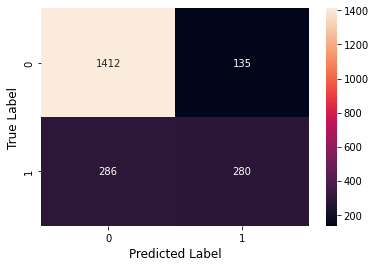

In [14]:
cat_confusion_matrix = metrics.confusion_matrix(Y_test, pred_cat)
sns.heatmap(cat_confusion_matrix, annot=True, fmt="d")

plt.xlabel("Predicted Label", fontsize= 12)
plt.ylabel("True Label", fontsize= 12)

plt.show()

In [15]:
print(metrics.classification_report(Y_test, pred_cat, labels = [0, 1]))

              precision    recall  f1-score   support

           0       0.83      0.91      0.87      1547
           1       0.67      0.49      0.57       566

    accuracy                           0.80      2113
   macro avg       0.75      0.70      0.72      2113
weighted avg       0.79      0.80      0.79      2113



ROC_AUC:  0.8439159572499835


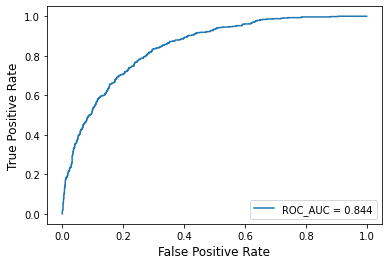

In [16]:
cat_pred_proba = cat_model.predict_proba(X_test)[:,1]

cat_roc_auc = metrics.roc_auc_score(Y_test, cat_pred_proba)
print('ROC_AUC: ', cat_roc_auc)

cat_fpr, cat_tpr, thresholds = metrics.roc_curve(Y_test, cat_pred_proba)

plt.plot(cat_fpr,cat_tpr, label = 'ROC_AUC = %0.3f' % cat_roc_auc)

plt.xlabel("False Positive Rate", fontsize= 12)
plt.ylabel("True Positive Rate", fontsize= 12)
plt.legend(loc="lower right")

plt.show()

## <a id="46">Feature Importance and SHAP Plot</a>

Let’s see what features have more importance for the Catboost’s predictions.

In [17]:
pool = Pool(X_train, Y_train, cat_features=categorical_ft)

Feature_importance = pd.DataFrame({'feature_importance': cat_model.get_feature_importance(pool), 
                      'feature_names': X_train.columns}).sort_values(by=['feature_importance'], 
                                                           ascending=False)

Feature_importance

,feature_importance,feature_names
4,24.507032,tenure
17,18.390073,MonthlyCharges
14,16.429965,Contract
18,6.125202,TotalCharges
11,5.949266,TechSupport
15,5.046415,PaperlessBilling
8,4.577087,OnlineSecurity
16,3.663959,PaymentMethod
1,3.202436,SeniorCitizen
7,3.110529,InternetService


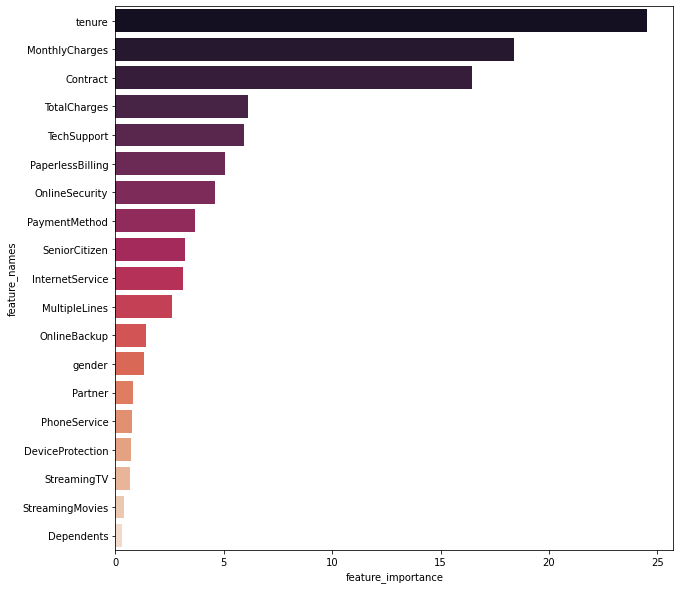

In [18]:
plt.figure(figsize=(10,10))

sns.barplot(x=Feature_importance['feature_importance'], y=Feature_importance['feature_names'], palette = 'rocket')

plt.show()

Select the most importat features to generate all possible combination of the features. 
Due to large range of numeric features we need to quantise the features values. 

In [19]:
data_enc.columns
data_enc.nunique()
features = []
features_name = []
for col in data_enc:
#   print(df[col].unique())
    if len (data_enc[col].unique())>10:
        min_f = min(data_enc[col].unique())
        max_f = max(data_enc[col].unique())
        new_range = np.linspace(min_f, max_f, 10)
        features.append(new_range)
        features_name.append(col)
    elif col =='PaymentMethod'  or col =='Contract' or col== 'MultipleLines' or col== 'SeniorCitizen' or col == 'OnlineSecurity' or col =='TechSupport' or col=='PaperlessBilling':
        
        features.append(data_enc[col].unique())
        features_name.append(col)
        
print (features)


[array([0, 1]), array([ 0.,  8., 16., 24., 32., 40., 48., 56., 64., 72.]), array(['No', 'Yes', 'No phone service'], dtype=object), array(['No', 'No internet service', 'Yes'], dtype=object), array(['No', 'No internet service', 'Yes'], dtype=object), array(['Month-to-month', 'One year', 'Two year'], dtype=object), array(['Yes', 'No'], dtype=object), array(['Electronic check', 'Mailed check', 'Bank transfer (automatic)',
       'Credit card (automatic)'], dtype=object), array([ 18.25      ,  29.41666667,  40.58333333,  51.75      ,
        62.91666667,  74.08333333,  85.25      ,  96.41666667,
       107.58333333, 118.75      ]), array([  18.8       ,  981.68888889, 1944.57777778, 2907.46666667,
       3870.35555556, 4833.24444444, 5796.13333333, 6759.02222222,
       7721.91111111, 8684.8       ])]


generate all possible combination

In [20]:
import itertools
combination = list(itertools.product(*features))

Filter the dataset based on the most important features

In [21]:
data_enc1 = data_enc[features_name]



Convert the nominal value to the numeric one

In [22]:
yes_or_no_map = {'No': 0, 'Yes': 1} #seniorcitizen, partner, dependents, phoneservice, paperlessbilling
multiplelines_map = {'No phone service': -1, 'No': 0, 'Yes': 1}
add_netservices_map = {'No internet service': -1, 'No': 0, 'Yes': 1} #onlinesecurity, onlinebackup, deviceprotection,techsupport,streaming services
contract_map = {'Month-to-month': 0, 'One year': 1, 'Two year': 2}
paymentmethod_map = {'Electronic check': 0, 'Mailed check': 1, 'Bank transfer (automatic)': 2, 'Credit card (automatic)': 3}




# data_enc1['SeniorCitizen'] = data_enc1['SeniorCitizen'].map(yes_or_no_map).stype('int')
data_enc1['MultipleLines'] = data_enc1['MultipleLines'].map(multiplelines_map).astype('int')
data_enc1['OnlineSecurity'] = data_enc1['OnlineSecurity'].map(add_netservices_map).astype('int')
data_enc1['TechSupport'] = data_enc1['TechSupport'].map(add_netservices_map).astype('int')
data_enc1['Contract'] = data_enc1['Contract'].map(contract_map).astype('int')
data_enc1['PaperlessBilling'] = data_enc1['PaperlessBilling'].map(yes_or_no_map).astype('int')
data_enc1['PaymentMethod'] = data_enc1['PaymentMethod'].map(paymentmethod_map).astype('int')


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/

Scale the float features with the large range to 20 different scale via closest value.

In [23]:

data_enc2 = data_enc1.copy()
for index, row in data_enc1.iterrows():

    absolute_difference_function_tc = lambda list_value : abs(list_value - data_enc1.loc[index,'TotalCharges'])
    closest_value_tc = min(features[9], key=absolute_difference_function_tc)
    data_enc2.loc[index, 'TotalCharges']= closest_value_tc

    absolute_difference_function_mc = lambda list_value : abs(list_value - data_enc1.loc[index,'MonthlyCharges'])
    closest_value_mc = min(features[8], key=absolute_difference_function_mc)
    data_enc2.loc[index, 'MonthlyCharges']= closest_value_mc

    absolute_difference_function_t = lambda list_value : abs(list_value - data_enc1.loc[index,'tenure'])
    closest_value_t = min(features[1], key=absolute_difference_function_t)
    data_enc2.loc[index, 'tenure']= closest_value_t

    

Apply K-means on original data to cluster them to several groups.
We need to do this to reduce the amount of Comparison by the all possible combinations.


In [24]:
from sklearn.cluster import KMeans
import numpy as np

kmeans = KMeans(n_clusters=150, random_state=0).fit(data_enc2)
kcenter = kmeans.cluster_centers_




Train the KNN by feeding all center samples to it :).

In [25]:

from sklearn.neighbors import NearestNeighbors
neigh = NearestNeighbors(n_neighbors=1)
neigh.fit(kcenter)

NearestNeighbors(n_neighbors=1)

Then the next step could be one of these two different pathes:
    
    - feed all sample one by one and extract their  Corresponding ks test or p-value;
    
    - apply the Kmeans and then get the centers and finnaly get the corresponding P-value.
    
    

In [26]:

df_combination = pd.DataFrame (combination,columns=features_name)
df_combination['MultipleLines'] = df_combination['MultipleLines'].map(multiplelines_map).astype('int')
df_combination['OnlineSecurity'] = df_combination['OnlineSecurity'].map(add_netservices_map).astype('int')
df_combination['TechSupport'] = df_combination['TechSupport'].map(add_netservices_map).astype('int')
df_combination['Contract'] = df_combination['Contract'].map(contract_map).astype('int')
df_combination['PaperlessBilling'] = df_combination['PaperlessBilling'].map(yes_or_no_map).astype('int')
df_combination['PaymentMethod'] = df_combination['PaymentMethod'].map(paymentmethod_map).astype('int')
df_combination.sort_index(inplace =True)


In [27]:
# df_combination.shape
list_dist = []
for index, row in df_combination.iterrows(): 
    list_dist.append(neigh.kneighbors([df_combination.iloc[index].values]))

In [28]:
kmeans_comb = KMeans(n_clusters=100, random_state=0).fit(df_combination)
kmeans_comb_center = kmeans_comb.cluster_centers_


In [31]:
kmeans_comb_center

array([[5.00000000e-01, 5.71428571e+01, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 1.00000000e+00, 5.00000000e-01, 1.50000000e+00,
        1.08380952e+02, 5.79613333e+03],
       [5.00000000e-01, 4.14545455e+01, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 1.00000000e+00, 5.00000000e-01, 1.50000000e+00,
        3.55075758e+01, 1.94457778e+03],
       [5.00000000e-01, 4.26666667e+01, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 1.00000000e+00, 5.00000000e-01, 1.50000000e+00,
        4.18240741e+01, 8.68480000e+03],
       [5.00000000e-01, 2.61818182e+01, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 1.00000000e+00, 5.00000000e-01, 1.50000000e+00,
        5.37803030e+01, 3.87035556e+03],
       [5.00000000e-01, 3.60000000e+01, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 1.00000000e+00, 5.00000000e-01, 1.50000000e+00,
        8.30166667e+01, 1.88000000e+01],
       [5.00000000e-01, 6.40000000e+01, 0.00000000e+00, 0.00000000e+00,
   

In [29]:
# from alibi_detect.od import IForest
# od = IForest(threshold=0.05, n_estimators=500)

# od.fit(X_train.values)
X_train.shape
cd = TabularDrift(X_train.values, p_val=.05, categories_per_feature=categories_per_feature)

In [30]:

# od_preds = od.predict(X_test, return_instance_score=True)
# print(od_preds)
#
#col #34 is the monthly bill amount
X_test_1['tenure']=40
X_test_1['MonthlyCharges']=40
X_test_1['TotalCharges']=7000

input_with_insane_monthly_charges = X_test_1.iloc[2]
# input_with_insane_monthly_charges.values[34] = 22975.0
# input_with_insane_monthly_charges.values[35] = 25000.0
print(input_with_insane_monthly_charges.values.reshape(1,19))

cd_preds = cd.predict(input_with_insane_monthly_charges.values.reshape(1,19))
print(cd_preds)

# from alibi_detect.cd import MMDDrift

# cd1 = MMDDrift(X_train.values, backend='tensorflow', p_val=.05)
# preds = cd1.predict(input_with_insane_monthly_charges.values.reshape(1,19))
# print(preds)


[['Female' 0 'No' 'No' 40 'Yes' 'Yes' 'DSL' 'No' 'Yes' 'No' 'Yes' 'No'
  'Yes' 'Month-to-month' 'No' 'Credit card (automatic)' 40 7000]]
{'data': {'is_drift': 0, 'distance': array([0.50283974, 0.16673428, 0.48640972, 0.30040568, 0.60182554,
       0.09817445, 0.5768763 , 0.6549696 , 0.50283974, 0.65740365,
       0.55375254, 0.70831645, 0.5951319 , 0.60993916, 0.4511156 ,
       0.59817445, 0.56876266, 0.73833674, 0.9523327 ], dtype=float32), 'p_val': array([0.9943205 , 1.        , 1.        , 1.        , 0.79634887,
       1.        , 0.8462475 , 0.69006085, 0.9943205 , 0.6851927 ,
       0.8924949 , 0.58336717, 0.8097363 , 0.7801217 , 1.        ,
       0.8036511 , 0.8624746 , 0.5233266 , 0.09533469], dtype=float32), 'threshold': 0.002631578947368421}, 'meta': {'name': 'TabularDrift', 'detector_type': 'offline', 'data_type': None}}



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
